# Survey Visualizatoin
This notebook helps a user locate the start and stop times of different surveys patterns

In [1]:
import os
import sys
from pathlib import Path
import json
import pandas as pd
from datetime import datetime, timedelta
import tiledb
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.dates as mdates

from es_sfgtools.processing.pipeline import DataHandler
from es_sfgtools.utils.archive_pull import (
    list_survey_files
    )

from es_sfgtools.utils.loggers import set_all_logger_levels, GNSSLogger, ProcessLogger


## Step 1. Set Survey parameters, get DFOP00 files, and read them into a shotdata array.


In [7]:
# Input survey parameters
network='cascadia-gorda'
site='GCC1'
#campaign='2024_A_1126'
#campaign='2023_A_1063'
campaign='2022_A_1065'
vessel_type = 'SV3'

#Need to provide some start/end dates or get_pipeline() fails validation.
start = datetime(year=int(campaign.split('_')[0]), month=1, day=1)
end = datetime(year=int(campaign.split('_')[0]), month=12, day=31)


# Set data directory path for local environment
data_dir = Path(f"{os.path.expanduser('~/data/sfg')}")
os.makedirs(data_dir, exist_ok=True)

#### USE THE FOLLOWING DEFAULTS UNLESS DESIRED####
data_handler = DataHandler(directory=data_dir)
data_handler.change_working_station(network=network, station=site, campaign=campaign, start_date=start, end_date=end)
#BaseLogger.set_dir(data_handler.station_log_dir)

if vessel_type == 'SV3':
    pipeline, config = data_handler.get_pipeline_sv3()
elif vessel_type == 'SV2':
    pipeline, config = data_handler.get_pipeline_sv2()
else:
    raise ValueError(f"Vessel type {vessel_type} not recognized")

shotdata_uri = f"/Users/gottlieb/data/sfg/{network}/{site}/TileDB/shotdata_db.tdb"
#metadata_uri = f"/Users/gottlieb/data/sfg/{network}/{site}/{site}_update_times.json"
metadata_uri = f"/Users/gottlieb/data/sfg/{network}/{site}/{site}.json"

Building directory structure for cascadia-gorda GCC1 2022_A_1065
Building TileDB arrays for GCC1
Changed working station to cascadia-gorda GCC1


In [3]:
#get DFOP00 files
remote_filepaths = list_survey_files(network=network, station=site, survey=campaign, show_details=True)
data_handler.add_data_remote(remote_filepaths=remote_filepaths)
data_handler.download_data(file_types='dfop00', override=False)

Listing survey files from url https://gage-data.earthscope.org/archive/seafloor/cascadia-gorda/GCC1/2022_A_1065/raw
Found under https://gage-data.earthscope.org/archive/seafloor/cascadia-gorda/GCC1/2022_A_1065/raw:
    121 NOV000 file(s)
    49 NOV770 file(s)
    9 DFOP00 file(s)
33 files not recognized and skipped
Added 0 out of 170 files to the catalog
No new AssetType.DFOP00 files to download


In [4]:
#read DFOP00 files into shotdata array
pipeline.process_dfop00()

Found 1 DFOP00 Files to Process


Processing DFOP00 Files:   0%|          | 0/1 [00:00<?, ?it/s]

Failed to Process /Users/gottlieb/data/sfg/cascadia-gorda/GCC1/2022_A_1065/raw/329653_002_20220519_191826_00100_DFOP00.raw
Generated 0 ShotData dataframes From 1 DFOP00 Files


In [8]:
def read_df(uri, start: datetime, end: datetime = None, **kwargs) -> pd.DataFrame:
    """ 
    Read a dataframe from the array between the start and end dates 
    
    Args:
        start (datetime.datetime): The start date
        end (datetime.datetime, optional): The end date. Defaults to None.
    
    Returns:
        pd.DataFrame: dataframe
    """ 

    print(f"Reading dataframe from {uri} for {start} to {end}")
    # TODO slice array by start and end and return the dataframe
    if end is None:
        end = start + timedelta(days=1)
    with tiledb.open(str(uri), mode="r") as array:
        try:
            df = array.df[slice(np.datetime64(start), np.datetime64(end)),:]
        except IndexError as e:
            print(e)
            return None
    # self.dataframe_schema.validate(df, lazy=True)
    return df


campaign_start = data_handler.date_range[0]
campaign_end = data_handler.date_range[1]
df = read_df(shotdata_uri, start=campaign_start, end=campaign_end)
df

Reading dataframe from /Users/gottlieb/data/sfg/cascadia-gorda/GCC1/TileDB/shotdata_db.tdb for 2022-01-01 00:00:00 to 2022-12-31 00:00:00


,triggerTime,transponderID,head0,pitch0,roll0,head1,pitch1,roll1,east0,north0,...,east_std,north_std,up_std,pingTime,returnTime,tt,dbv,xc,snr,tat
0,2022-05-11 12:29:24.870,5209,310.714203,-3.195092,-0.615009,307.975647,1.652172,0.225708,-2771184.25,-3884325.00,...,10.201,10.581,27.600000,1.652297e+09,1.652297e+09,4.272079,249,94,42.0,0.20
1,2022-05-11 12:29:39.870,5209,303.912079,-1.624977,-0.790559,310.749908,0.283859,-2.790508,-2771188.75,-3884319.50,...,10.165,10.559,27.600000,1.652297e+09,1.652297e+09,4.271120,249,85,29.0,0.20
2,2022-05-11 12:29:54.870,5209,342.710785,1.758465,1.211893,336.945160,-1.293341,3.274448,-2771190.75,-3884314.75,...,10.147,10.591,27.600000,1.652297e+09,1.652297e+09,4.270107,248,93,40.0,0.20
3,2022-05-11 12:30:09.870,5209,343.112213,0.079027,-0.130682,344.100677,-1.204100,2.770489,-2771188.00,-3884310.50,...,10.120,10.623,27.600000,1.652297e+09,1.652297e+09,4.268335,248,90,19.0,0.20
4,2022-05-11 12:30:24.870,5209,324.408203,-2.784047,0.657875,316.173035,2.230299,0.295409,-2771186.50,-3884306.50,...,8.077,10.602,25.299999,1.652297e+09,1.652297e+09,4.266186,249,82,33.0,0.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116621,2022-05-19 06:04:16.870,5211,40.693748,-2.241217,2.221842,9.256187,12.120378,-4.863576,-2771965.00,-3885527.00,...,8.274,11.297,25.299999,1.652965e+09,1.652965e+09,5.602116,237,54,2.0,0.44
116622,2022-05-19 06:04:31.870,5211,348.457916,1.094959,-2.302079,356.531891,-0.715436,2.535453,-2771956.25,-3885525.50,...,8.274,11.297,25.299999,1.652965e+09,1.652965e+09,5.603377,234,78,13.0,0.44
116623,2022-05-19 06:04:46.870,5211,353.647705,5.230536,-4.062319,359.502075,5.619102,2.487816,-2771952.25,-3885519.25,...,8.269,11.305,25.299999,1.652965e+09,1.652965e+09,5.606027,232,88,7.0,0.44
116624,2022-05-19 06:05:01.870,5211,0.606757,-6.593843,-0.120640,349.740204,-2.577729,-9.474074,-2771947.75,-3885514.50,...,8.305,11.302,25.299999,1.652966e+09,1.652966e+09,5.607853,237,78,11.0,0.44


## Plot waveglider locations

In [9]:
#start with no surveys, or load some from the metadata if exists

surveys = []

#meta = json.loads(Path(metadata_uri).read_text())
#surveys = meta['campaigns'][0]['surveys']

surveys

[]

In [10]:
def plot_en(df, surveys, save_as=None):
    fig, axs = plt.subplots(nrows=2, figsize=(16,10))  
    #title = f"{survey_name} {survey_type}"
    #save_as = f"{survey_name}_{survey_type}_en.png"
    #fig.suptitle(title)
    axs[0].set_ylabel("East (m)")
    axs[1].set_ylabel("North (m)")
    # colormap_times = df["triggerTime"].apply(lambda x:x.timestamp()).to_numpy()
    # colormap_times_scaled = (colormap_times - colormap_times.min())/3600
    # norm = Normalize(
    #     vmin=0,
    #     vmax=(colormap_times.max() - colormap_times.min()) / 3600,
    # )
    sc0 = axs[0].scatter(
        df["triggerTime"],
        df["east0"],
        # c=colormap_times_scaled,
        # cmap="viridis",
        # norm=norm,
        alpha=0.25
    )
    sc1 = axs[1].scatter(
        df["triggerTime"],
        df["north0"],
        # c=colormap_times_scaled,
        # cmap="viridis",
        # norm=norm,
        alpha=0.25
    )

    survey_colors = cm.rainbow(np.linspace(0, 1, len(surveys)))
    for ax in axs:
        for i, survey in enumerate(surveys):
            start = survey['start']
            end = survey['end']
            label = survey['type'] + " " + survey.get('notes',"")
            ax.axvspan(pd.to_datetime(start),pd.to_datetime(end), color=survey_colors[i], alpha=0.3, label=label)
            #ax.axvline(x=pd.to_datetime(end), color='r', linestyle='--')
        # Make ticks on occurrences of each month:
        ax.xaxis.set_major_locator(mdates.DayLocator())
        # Get only the month to show in the x-axis:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        
    plt.xticks(rotation=90)
    axs[0].legend()
    if save_as is not None:
        plt.savefig(save_as)

def plot_wg_position(df, survey_name, survey_type, start, end):
    
    temp_df = df[df['triggerTime']>=start]
    temp_df = temp_df[df['triggerTime']<=end]
    fig, ax = plt.subplots(figsize=(16,10))
    title = f"{survey_name} {survey_type} from {start.isoformat()} to {end.isoformat()}"
    save_as = f"{survey_name}_{survey_type}.png"
    fig.suptitle(title)
    ax.set_xlabel("East (m)")
    ax.set_ylabel("North (m)")
    #ax.scatter(0,0,label="Origin",color="magenta",s=100)
    colormap_times = temp_df["triggerTime"].apply(lambda x:x.timestamp()).to_numpy()
    colormap_times_scaled = (colormap_times - colormap_times.min())/3600

    norm = Normalize(
        vmin=0,
        vmax=(colormap_times.max() - colormap_times.min()) / 3600,
    )
    sc = ax.scatter(
        temp_df["east0"],
        temp_df["north0"],
        c=colormap_times_scaled,
        cmap="viridis",
        label="Antenna Position",
        norm=norm,
        alpha=0.25
    )
    cbar = plt.colorbar(sc,label="Time (hr)",norm=norm)
    ax.legend()
    plt.savefig(save_as)
    print(temp_df.triggerTime.iloc[0].isoformat(), temp_df.triggerTime.iloc[-1].isoformat())


2022-05-11T12:29:24.870000 2022-05-19T06:05:16.870000


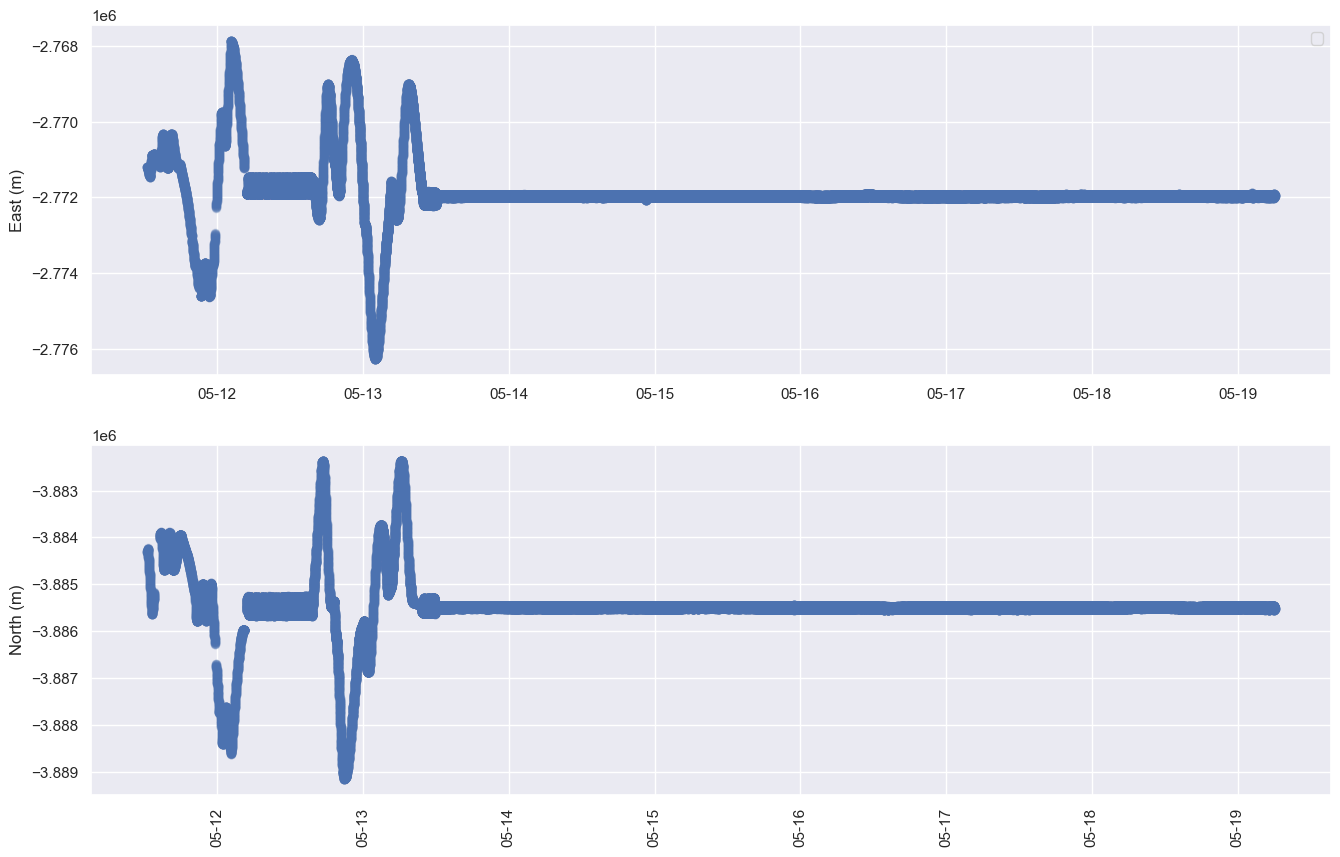

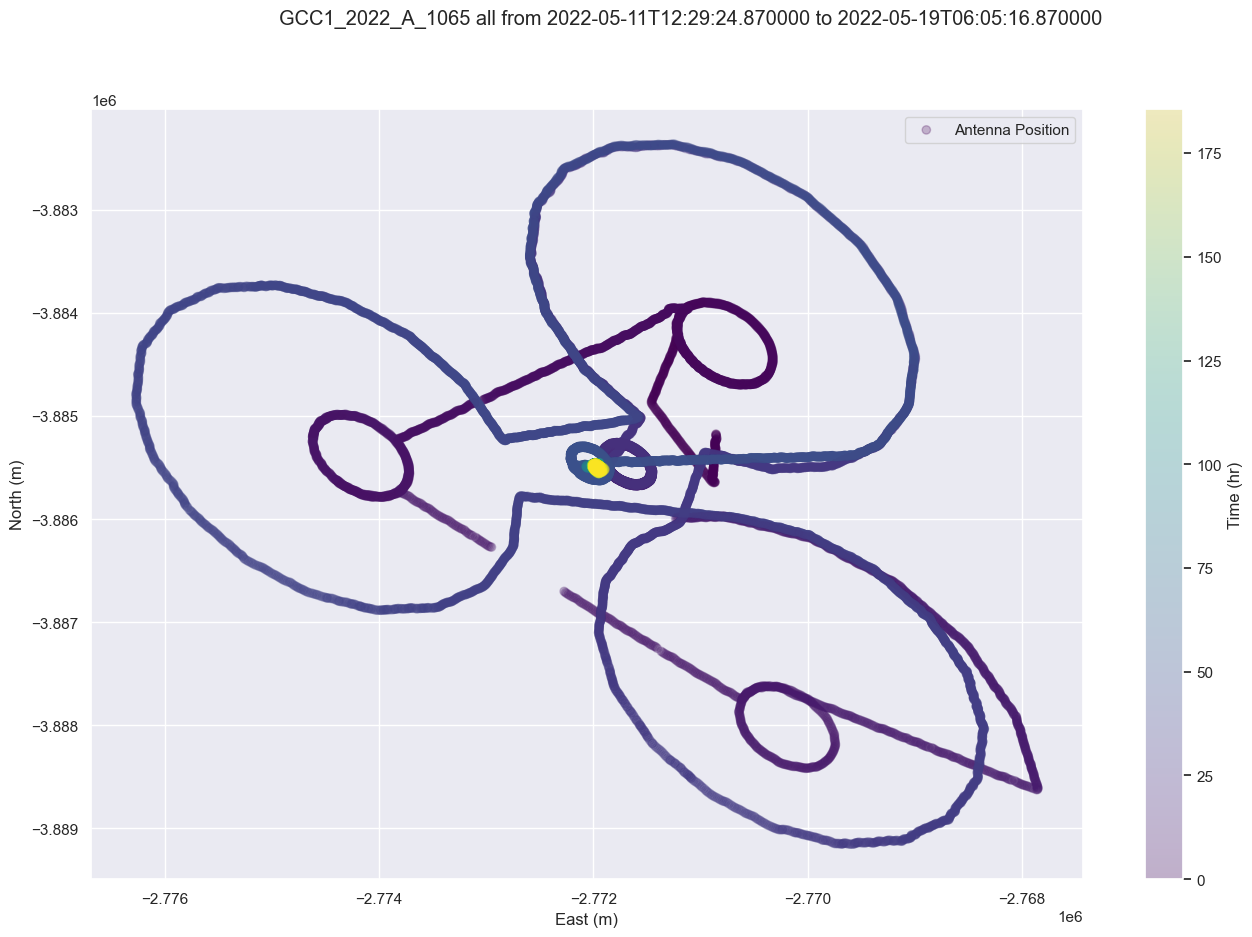

In [11]:
#adjust to remove any junk data at beginning or end if needed
start = df.triggerTime.iloc[0] + timedelta(hours=0)
end = df.triggerTime.iloc[-1]
temp_df = df[df['triggerTime']>=start]
temp_df = temp_df[df['triggerTime']<=end]

plot_en(temp_df, surveys)
plot_wg_position(df, f"{site}_{campaign}", "all", start, end)

In [ ]:
##Update these for the survey you want to plot
survey_name = f"{site}_{campaign}_4"
survey_type = "fixed"
start = datetime.fromisoformat("2022-05-04T22:00:00")
end = datetime.fromisoformat("2022-05-10T12:17:00")

##if you already have a survey in the metadata, you can load it and adjust from there
#start = datetime.fromisoformat(survey['start'])
#end = datetime.fromisoformat(survey['end'])
# start += timedelta(hours=0)
# end -= timedelta(hours=6)

print(start.isoformat(), end.isoformat())

survey = {
    'start': start.isoformat(),
    'end': end.isoformat(),
    'type': survey_type,
    'name': survey_name
}
plot_en(temp_df, [survey])
plot_wg_position(df, survey_name, survey_type, start, end)

In [ ]:
#use library tools to add survey to metadata
# not yet implemented

In [ ]:
#before running this cell, update the json file with the new surveys

meta = json.loads(Path(metadata_uri).read_text())
for campaign_meta in meta['campaigns']:
    if campaign_meta['name'] == campaign:   
        surveys = campaign_meta['surveys']

plot_en(temp_df, surveys, save_as=f"{site}_{campaign}_surveys.png")

In [ ]:
survey=surveys[4]
survey_name = f"{site}_{survey['id']}"
survey_type = survey['type']
start = datetime.fromisoformat(survey['start'])
end = datetime.fromisoformat(survey['end'])
plot_wg_position(df, survey_name, survey_type, start, end)
print(start.isoformat(), end.isoformat())

In [ ]:
campaign

In [ ]:
for survey in surveys:
    survey_name = f"{site}_{survey['id']}"
    survey_type = survey['type']
    start = datetime.fromisoformat(survey['start'])
    end = datetime.fromisoformat(survey['end'])
    plot_wg_position(df, survey_name, survey_type, start, end)